In [1]:
from database.strategy import Strategy
from database.sec import SEC
from database.market import Market
from database.weather import Weather
from transformer.date_transformer import DateTransformer
from transformer.column_transformer import ColumnTransformer
from transformer.model_transformer import ModelTransformer
from transformer.product_transformer import ProductTransformer
from transformer.predictor_transformer import PredictorTransformer
from preprocessor.model_preprocessor import ModelPreprocessor
from preprocessor.predictor_preprocessor import PredictorPreprocessor
from modeler.modeler import Modeler as sp
from utils.date_utils import DateUtils
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from tqdm import tqdm
import math
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, accuracy_score, mean_absolute_percentage_error
import numpy as np

In [2]:
## reading in the data
telecom = pd.read_csv("telecom_users.csv")

In [3]:
## quick cleaning
tc = telecom.drop(["Unnamed: 0","customerID"],axis=1)
cleaned_charges = []
## converting total charges from an object to numerical values
for charge in tc["TotalCharges"]:
    try:
        new_charge = float(charge)
    except:
        new_charge = np.NAN
    cleaned_charges.append(new_charge)    

In [4]:
## replacing the old values with new values
tc["TotalCharges"] = cleaned_charges

In [5]:
## getting rid of non included values
tc = tc.dropna()

In [6]:
## converting string categories to binary categories
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
numerical_values = tc[["tenure","MonthlyCharges","TotalCharges"]]
cleaned = enc.fit_transform(tc.drop(["tenure","MonthlyCharges","TotalCharges"],axis=1))
columns = enc.get_feature_names()
cleaned_df = pd.DataFrame(cleaned,columns=columns)

In [7]:
## merging
for col in cleaned_df:
    numerical_values[col] = cleaned_df[col]

In [8]:
## splitting the dataset by 70 % for train and test
training_data = numerical_values.iloc[:int(len(numerical_values)*0.7)]
test_data = numerical_values.iloc[int(len(numerical_values)*0.7):]
refined = {"X":training_data.drop(["tenure","TotalCharges"],axis=1),"y":training_data["tenure"]}

In [9]:
## running the actual modeling
rfr = sp.regression(refined,ranked=False,tf=True,deep=False).sort_values("score",ascending=False).iloc[0]

In [19]:
numerical_values["calc"] = numerical_values["TotalCharges"] / numerical_values["MonthlyCharges"]

In [20]:
numerical_values[[
    'calc',"tenure"
]]

,calc,tenure
0,71.977178,72
1,45.073171,44
2,38.290193,38
3,4.266547,4
4,2.235734,2
...,...,...
5981,1.000000,1
5982,24.130626,23
5983,14.470449,12
5984,12.067873,12


In [10]:
rfr

api                                                         xgb
model         XGBRegressor(base_score=0.5, booster='gblinear...
score                                                  -11.9643
model_type                                           regression
Name: 2, dtype: object

In [11]:
## this is the test component
model = rfr["model"]
predictions = model.predict(test_data.drop(["tenure","TotalCharges"],axis=1))
score = mean_squared_error(predictions,test_data["tenure"])

In [12]:
## we're converting the categorical data to a unified numerical data format
analysis = tc[int(len(tc)*0.7):]
analysis["predictions"] = predictions
funny = []
for row in analysis.iterrows():
    agg = ""
    for column in analysis.columns:
        if column not in ["tenure","MonthlyCharges","TotalCharges"]:
            agg = agg + str(row[1][column])
    funny.append(agg)
analysis["funny"] = funny
le = LabelEncoder()
analysis["fn"] = le.fit_transform(analysis["funny"])

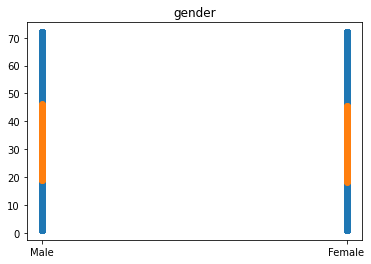

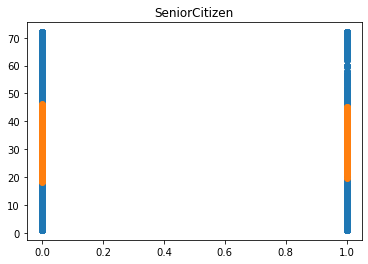

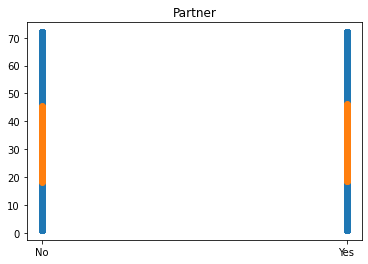

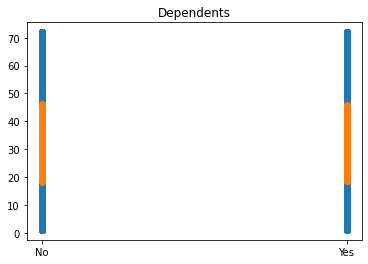

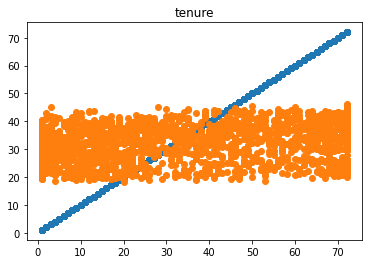

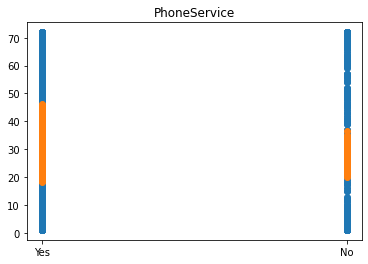

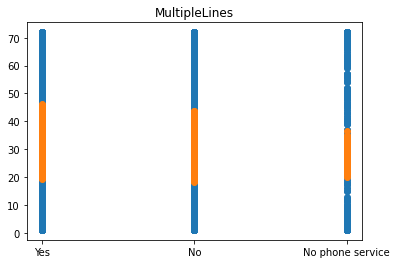

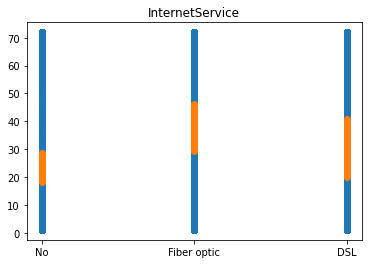

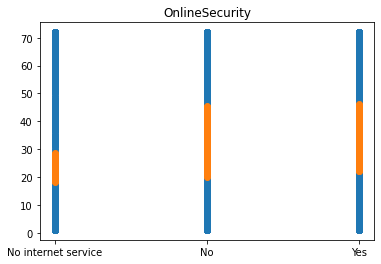

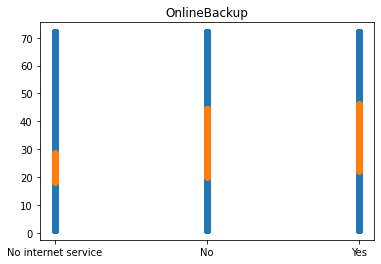

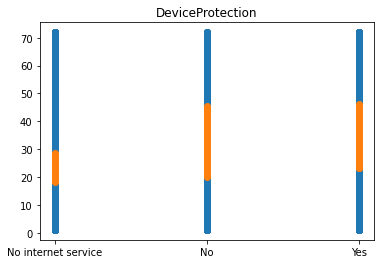

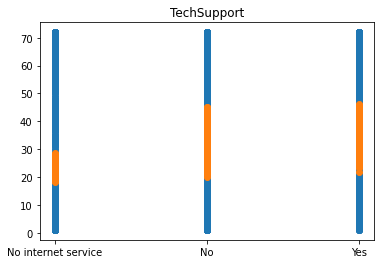

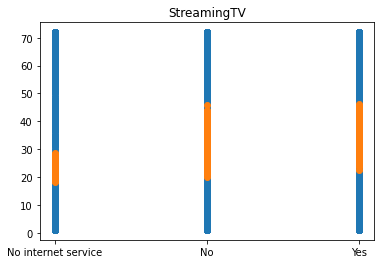

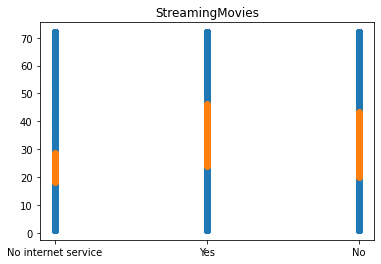

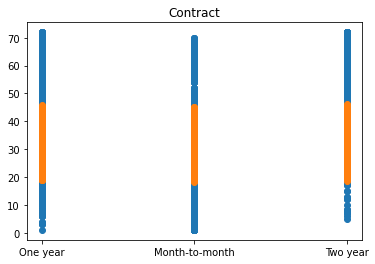

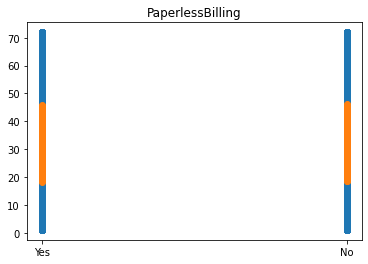

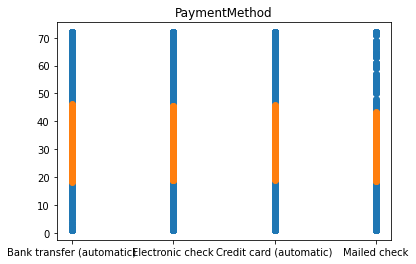

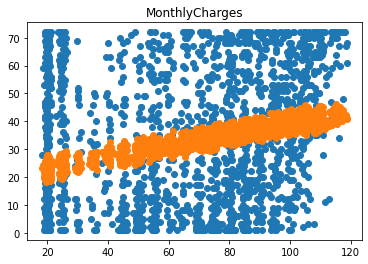

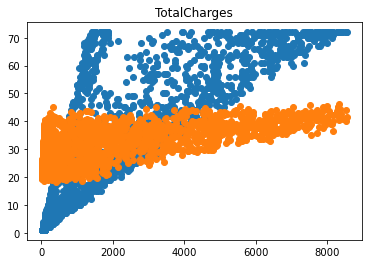

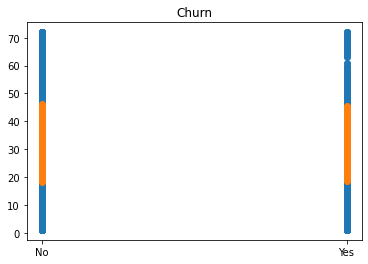

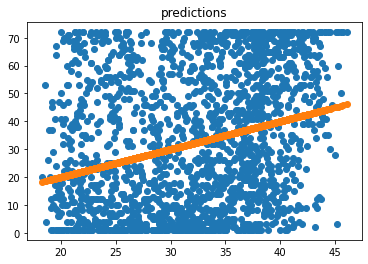

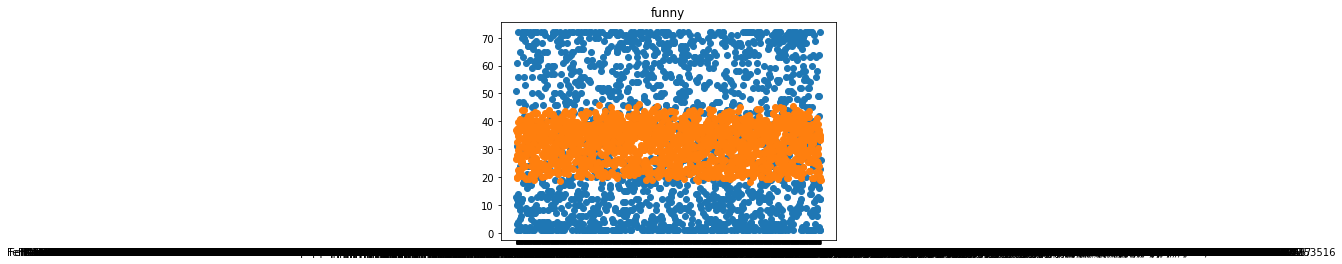

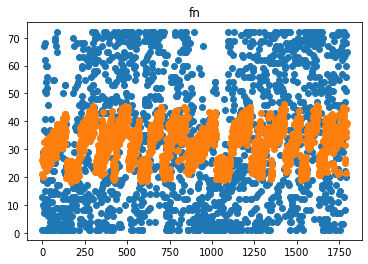

In [13]:
## visualizing
for col in analysis.columns:
    plt.scatter(analysis[col],analysis["tenure"])
    plt.scatter(analysis[col],analysis["predictions"])
    plt.title(col)
    plt.show()

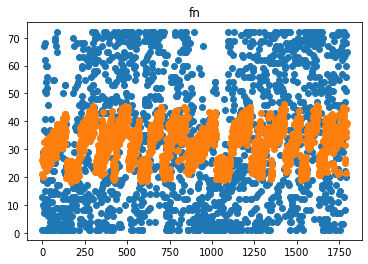

In [14]:
## visualizing
plt.scatter(analysis["fn"],analysis["tenure"])
plt.scatter(analysis["fn"],analysis["predictions"])
plt.title(col)
plt.show()

In [15]:
analysis[["fn","tenure"]].corr()

,fn,tenure
fn,1.000000,0.154371
tenure,0.154371,1.000000


In [16]:
import pickle
rfr["model"]  = pickle.dumps(rfr["model"])

In [17]:
rfr

api                                                         xgb
model         b'\x80\x04\x95\x9f\r\x00\x00\x00\x00\x00\x00\x...
score                                                  -11.9643
model_type                                           regression
Name: 2, dtype: object

In [18]:
db = Strategy("telecom")
db.connect()
db.store_data("tc_strategy",pd.DataFrame([rfr]))
db.close()

# Conclusions
### We were able to train a model that can accurately predict customer tenure based on the data provided, however we were unable to find any distinct connection to any given variable. In short, all variables are required to predict an accurate output. Project improvements include modeling other values provided by the given dataset, dwelving into possible methods of data summarization, and prolonging modeling time. Deployment of said model is recommended for a test demographic.